# SES 722: Econometry
## TP d'économétrie de *Mehdi Regina* et *Xavier Charef*

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import statsmodels as st
%matplotlib inline

from sklearn import linear_model
from scipy import stats
from scipy import special
import  statsmodels.formula.api as smfa

from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf as plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as plot_pacf
from statsmodels.tsa.stattools import acf as acf
from statsmodels.tsa.stattools import pacf as pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools  import adfuller as adfuller

## Partie 1: Regression 

### 1- Lire le fichier mroz.txt. Ne sélectionner que les observations pour lesquelles la variable wage est strictement positive.

In [13]:
header_wage = ['inlf', 'hours', 'kidslt6', 'kidsge6', 'age', 'educ', 'wage', 'repwage',
               'hushrs', 'husage', 'huseduc', 'huswage', 'faminc', 'mtr', 'motheduc',
               'fatheduc', 'unem', 'city', 'exper', 'nwifeinc', 'lwage', 'expersq']
#data_path = '/home/charef/cours/economie_droit/econometry/examen'

df_mroz = pd.read_table( "MROZ_2.raw",
                        sep="\s+", header=None, names=header_wage)
df_mroz.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800,0.6615,7,7,11.0,1,5,19.499980,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300,0.6215,12,14,9.5,1,7,20.100060,1.524272,49


In [14]:
df_mroz = df_mroz[df_mroz['wage'] > 0]
df_mroz.shape

(428, 22)

### 2- Faire les statistiques descriptives du salaire, de l’age et de l’éducation pour l’ensemble des femmes puis, pour les femmes dont le salaire du mari est supérieure à la médiane de l’échantillon, puis pour les femmes dont le salaire du mari est inférieur à la médiane de l’échantillon

In [15]:
df_reduit = df_mroz[['wage', 'age', 'educ']]
df_reduit.describe()

,wage,age,educ
count,428.000000,428.000000,428.000000
mean,4.177682,41.971963,12.658879
std,3.310282,7.721084,2.285376
min,0.128200,30.000000,5.000000
25%,2.262600,35.000000,12.000000
50%,3.481900,42.000000,12.000000
75%,4.970750,47.250000,14.000000
max,25.000000,60.000000,17.000000


In [16]:
sup_husb_wage = df_mroz['huswage'] > np.median(df_mroz['huswage'])
df_reduit_sup_husb_wage = df_reduit[sup_husb_wage]
df_reduit_sup_husb_wage.describe()

,wage,age,educ
count,214.000000,214.000000,214.000000
mean,4.896822,42.275701,13.242991
std,4.041606,7.388843,2.359045
min,0.161600,30.000000,5.000000
25%,2.513850,36.000000,12.000000
50%,3.846400,43.000000,12.000000
75%,5.854125,48.000000,16.000000
max,25.000000,59.000000,17.000000


In [17]:
inf_husb_wage = df_mroz['huswage'] <= np.median(df_mroz['huswage'])
df_reduit_inf_husb_wage = df_reduit[inf_husb_wage]
df_reduit_inf_husb_wage.describe()

,wage,age,educ
count,214.000000,214.000000,214.000000
mean,3.458541,41.668224,12.074766
std,2.143274,8.045482,2.054200
min,0.128200,30.000000,6.000000
25%,2.117275,35.000000,12.000000
50%,2.971800,41.000000,12.000000
75%,4.393800,47.000000,12.000000
max,18.267000,60.000000,17.000000


### 3- Faire l'histogramme de la variable wage. Calculer le log de wage et faire l'histogramme. Comparez les deux histogrammes et commentez

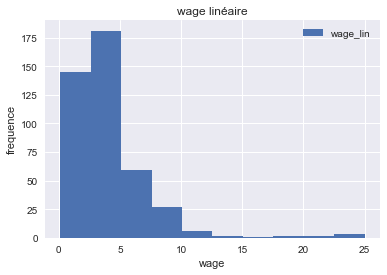

In [18]:
plt.hist(df_mroz['wage'], label='wage_lin')
plt.title('wage linéaire')
plt.xlabel('wage')
plt.ylabel('frequence')
plt.legend(loc='upper right')

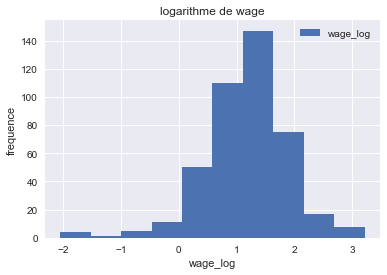

In [19]:
plt.hist(np.log(df_mroz['wage']), label='wage_log')
plt.title('logarithme de wage')
plt.xlabel('wage_log')
plt.ylabel('frequence')
plt.legend(loc='upper right')

On voit que la distribution du logarithme des salaires est moins biaisée. Il est donc préférable de choisir cette distribution logarithmique pour les tests statistiques qui suivent. Ces tests supposent une distribution gaussienne des résidus.

### 4- Calculer les corrélations motheduc et fatheduc. Commentez. Il y a-t-il un problème de multicollinéarité si l'on utilise ces variables comme variables explicatives ?

In [20]:
array_mother_father = np.array(df_mroz[['motheduc', 'fatheduc']])
corr = np.corrcoef(array_mother_father.T)
print(corr)

[[1.         0.55406322]
 [0.55406322 1.        ]]


La corrélation des 2 variables motheduc et fatheduc est de 0.55406322. Ces variables ne sont donc pas corrélées et on peut donc les utilisées comme variables explicatives sans craindre de problème de multicolinéarité entre motheduc et fatheduc.

### 5- Faites un graphique en nuage de point entre wage et educ, wage et exper, wage et fatheduc. Commentez. S'agit-il d'un effet "toute chose étant égale par ailleurs" ?

In [21]:
# Regression de wage en fonction de educ
array_educ = np.array(df_mroz['educ']).reshape(-1, 1)
y_wage = np.array(df_mroz['wage']).reshape(-1, 1)
n_wage_educ, k_wage_educ = array_educ.shape
X_educ = np.hstack((np.ones((n_wage_educ, 1)), array_educ))
print(X_educ.shape)
n_wage_educ, k_wage_educ = X_educ.shape
gram_X_educ = np.dot(X_educ.T, X_educ)
inv_gram_X_educ = np.linalg.inv(gram_X_educ)
mat_X_educ = np.dot(inv_gram_X_educ, X_educ.T)
beta_wage_educ = np.dot(mat_X_educ, y_wage)
SSE_wage_educ = np.sum((np.mean(y_wage) - np.dot(X_educ, beta_wage_educ))**2)
SST_wage = np.sum((np.mean(y_wage) - y_wage)**2)
R2_wage_educ = SSE_wage_educ / SST_wage
print(R2_wage_educ)

# Regression de wage en fonction de exper
array_exper = np.array(df_mroz['exper']).reshape(-1, 1)
y_wage = np.array(df_mroz['wage']).reshape(-1, 1)
n_wage_exper, k_wage_exper = array_exper.shape
X_exper = np.hstack((np.ones((n_wage_educ, 1)), array_exper))
print(X_exper.shape)
n_wage_exper, k_wage_exper = X_exper.shape
gram_X_exper = np.dot(X_exper.T, X_exper)
inv_gram_X_exper = np.linalg.inv(gram_X_exper)
mat_X_exper = np.dot(inv_gram_X_exper, X_exper.T)
beta_wage_exper = np.dot(mat_X_exper, y_wage)
SSE_wage_exper = np.sum((np.mean(y_wage) - np.dot(X_exper, beta_wage_exper))**2)
SST_wage = np.sum((np.mean(y_wage) - y_wage)**2)
R2_wage_educ = SSE_wage_exper / SST_wage
print(R2_wage_educ)

# Regression de wage en fonction de fatheduc
array_fatheduc = np.array(df_mroz['fatheduc']).reshape(-1, 1)
y_wage = np.array(df_mroz['wage']).reshape(-1, 1)
n_wage_fatheduc, k_wage_fatheduc = array_fatheduc.shape
X_fatheduc = np.hstack((np.ones((n_wage_fatheduc, 1)), array_fatheduc))
print(X_fatheduc.shape)
n_wage_fatheduc, k_wage_fatheduc = X_fatheduc.shape
gram_X_fatheduc = np.dot(X_fatheduc.T, X_fatheduc)
inv_gram_X_fatheduc = np.linalg.inv(gram_X_fatheduc)
mat_X_fatheduc = np.dot(inv_gram_X_fatheduc, X_fatheduc.T)
beta_wage_fatheduc = np.dot(mat_X_fatheduc, y_wage)
SSE_wage_fatheduc = np.sum((np.mean(y_wage) - np.dot(X_fatheduc, beta_wage_fatheduc))**2)
SST_wage = np.sum((np.mean(y_wage) - y_wage)**2)
R2_wage_educ = SSE_wage_fatheduc / SST_wage
print(R2_wage_educ)

(428, 2)
0.11693283505408893
(428, 2)
0.003024064672894571
(428, 2)
0.011607098663784525


Nous avons des $R^{2}$ très faibles. Ceci nous informe donc qu'il y a très peu de lien entre les valeurs prédites par ces modèles et les vraies valeurs de y. Il manque donc des variables significatives pour expliquer la variable wage. Ceci ne nous permet de vérifier l'effet ceteris paribus

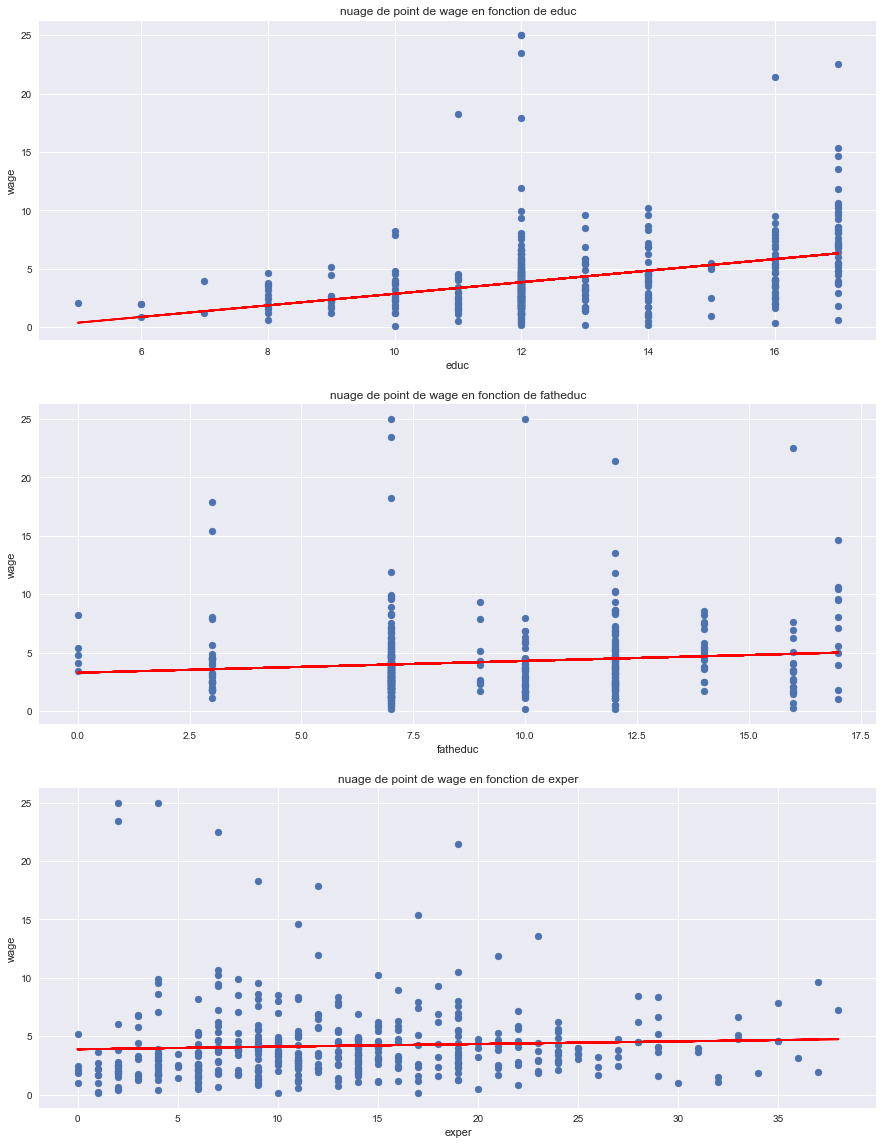

In [22]:
fig, axes = plt.subplots(3, 1,figsize=(15,20) )
axes[0].scatter(df_mroz['educ'], df_mroz['wage'])
axes[0].plot(df_mroz['educ'], np.dot(X_educ, beta_wage_educ),'r')
axes[0].set_ylabel('wage')
axes[0].set_xlabel('educ')
axes[0].set_title('nuage de point de wage en fonction de educ')
axes[2].scatter(df_mroz['exper'], df_mroz['wage'])
axes[2].plot(df_mroz['exper'], np.dot(X_exper, beta_wage_exper),'r')
axes[2].set_ylabel('wage')
axes[2].set_xlabel('exper')
axes[2].set_title('nuage de point de wage en fonction de exper')
axes[1].scatter(df_mroz['fatheduc'], df_mroz['wage'])
axes[1].plot(df_mroz['fatheduc'], np.dot(X_fatheduc, beta_wage_fatheduc),'r')
axes[1].set_ylabel('wage')
axes[1].set_xlabel('fatheduc')
axes[1].set_title('nuage de point de wage en fonction de fatheduc')


Au vue des graphes, on peut s'interroger sur le fait que la moyenne des résidus pour chaque tranche de nos variables explicatives soit constante. Ceci est nécessaire pour voir un effet "toute chose égale par ailleurs". 

Cet effet consiste à voir l'effet d'une variable explicative sur la variable expliquée à "toute chose égale par ailleurs". C'est-à-dire à tout autre variable constante (résidus compris). 

Il est donc nécessaire que u ne contienne pas de variable cachée corrélée à une variable explicative. Notre variable u doit donc avoir une espérance conditionnelle à nos variables explicatives constante (ie moyenne conditionnelle de u par rapport à X).

### 6- Quelle est l'hypothèse fondamentale qui garanti des estimateurs non biaisés ? Expliquer le biais de variable omise

L'hypothèse fondamentale correspond à avoir une espérance conditionnelle de la variable non observée par rapport à la variable explicative qui soit identique quelque soit la valeur de la variable explicative(ie: la moyenne des résidus pour chaque tranche de nos variables explicatives soit constante). 


Le biais de variable omise arrive lorsque nous ne respectons pas cette condition (cette condition influe directement sur la valeur du $\beta_{0}$ des modèles linéaires ci-dessus).

Notons que pour avoir le meilleur estimateur non-biaisée, il est nécéssaire de faire une hypothèse supplémentaire: avoir une variance de la variable cachée (résidu u) constante vis-à-vis des variables explicatives. C'est l'homoscédasticité. 
Les résidus sont centrés via la valeur de l'intercept de notre modèle régressif.

In [23]:
# Calculons l'espérance des résdus
u_educ = y_wage - np.dot(X_educ, beta_wage_educ)
E_educ = np.mean(u_educ)
print(E_educ)
#sig2_educ = np.dot(u_educ.T, u_educ) / (n - 2)
#std_educ = np.sqrt(np.diag(np.dot(sig2_educ, inv_gram_X_educ)))
#print(std_educ)

u_exper = y_wage - np.dot(X_exper, beta_wage_exper)
E_exper = np.mean(u_exper)
print(E_exper)
#sig2_exper = np.dot(u_exper.T, u_exper) / (n - 2)
#std_exper = np.sqrt(np.diag(np.dot(sig2_exper, inv_gram_X_exper)))
#print(std_exper)

u_fatheduc = y_wage - np.dot(X_fatheduc, beta_wage_fatheduc)
E_fatheduc = np.mean(u_fatheduc)
print(E_fatheduc)
#sig2_exper = np.dot(u_exper.T, u_exper) / (n - 2)
#std_exper = np.sqrt(np.diag(np.dot(sig2_exper, inv_gram_X_exper)))
#print(std_exper)

df_educ = pd.DataFrame(np.hstack((u_educ, np.array(df_mroz['educ']).reshape(-1,1))))
df_exper = pd.DataFrame(np.hstack((u_exper, np.array(df_mroz['exper']).reshape(-1,1))))
df_fatheduc = pd.DataFrame(np.hstack((u_fatheduc, np.array(df_mroz['fatheduc']).reshape(-1,1))))
means_educ = df_educ.groupby([1])[0].mean()
means_exper = df_exper.groupby([1])[0].mean()
means_fatheduc = df_fatheduc.groupby([1])[0].mean()

1.5007725073063798e-14
-5.14645439452409e-16
-2.1249876209647854e-15


Les moyennes de nos résidus sont donc très proches de 0. On peut donc supposer que l'espérance de nos résidus est nulle et donc avoir des résidus centrés.

In [24]:
print(means_educ[5:10])
print(means_exper[:5])
print(means_fatheduc[:10])

1
5.0     1.648325
6.0     0.733650
7.0     1.205008
8.0     0.732025
9.0     0.259055
10.0    0.362979
Name: 0, dtype: float64
1
0.0   -1.363280
1.0   -2.185810
2.0    0.712727
3.0   -0.340350
4.0    0.457708
5.0   -1.556638
Name: 0, dtype: float64
1
0.0     1.912892
3.0     0.810933
7.0    -0.197994
9.0     0.232469
10.0   -0.349588
Name: 0, dtype: float64


On remarque que les moyennes conditionnelles des résidus en fonction des variables explicatives sont très inégales. Ce qui implique que la condition fondamentale n'est pas respectée.

### 7- Faire la régression de wage en utilisant les variables explicatives une constante, city, educ, exper, nwifeinc, kidslt6, kidsge6. Commentez l'histogramme des résidus.

In [25]:
array_ = np.array(df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6','kidsge6']])
y_wage = np.array(df_mroz['wage']).reshape(-1, 1)
n, k = array_.shape
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_wage = np.dot(mat_X, y_wage)
u = y_wage - np.dot(X, beta_wage)

# Calcul de la standard deviation
sig2_MCO = np.dot(u.T, u) / (n - k)
std_MCO = np.sqrt(np.diag(sig2_MCO * inv_gram_X))

(428, 7)


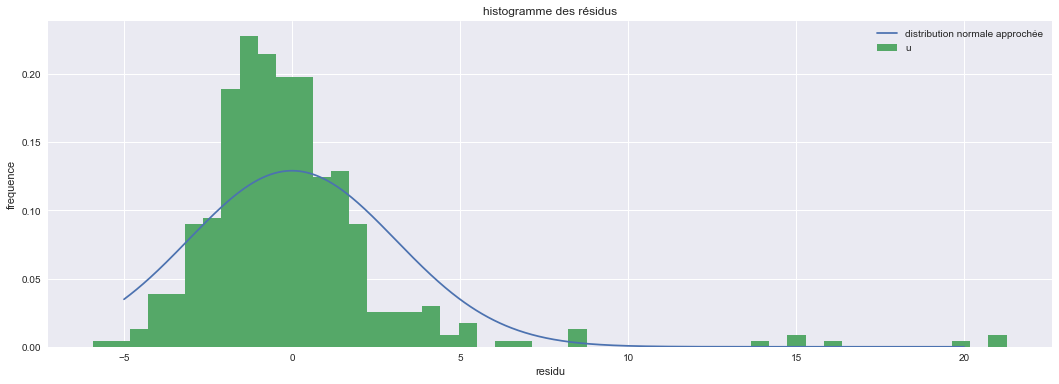

In [26]:
from scipy.stats import norm
mu_u, std_u = norm.fit(u)
x = np.linspace(-5, 20, 1000)
distrib_ = np.array(norm.pdf(x, mu_u, std_u))
fig, axes = plt.subplots(nrows=1, ncols=1,  figsize=(18, 6))
plt.plot(x,distrib_, label='distribution normale approchée')
plt.hist(u, label='u', normed=True, bins=50)
plt.title('histogramme des résidus')
plt.xlabel('residu')
plt.ylabel('frequence')
plt.legend(loc='upper right')

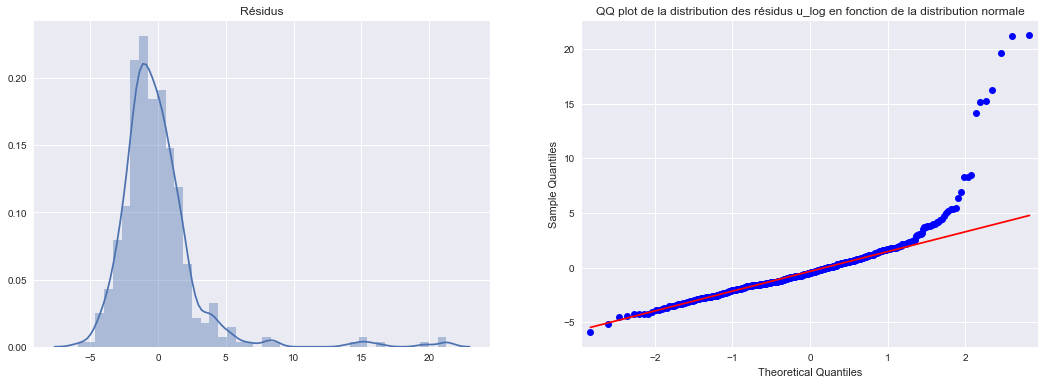

In [27]:
u_qqplot = list(u)
u_qqplot.sort()
u_qqplot = np.array(u_qqplot)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(u, ax=axes[0])

qqplot(u_qqplot, line='q', ax=axes[1])

axes[0].title.set_text('Résidus')
axes[1].title.set_text(
    'QQ plot de la distribution des résidus u_log en fonction de la distribution normale')
plt.show()

On remarque que les résidus n'ont pas une distribution gaussienne.
Le QQ-plot repésente les quantiles de x par rapport aux quantiles d'une distribution normale. En effet, on remarque que la distribution des résidus diffère largement d'une distribution normale pour les derniers quantiles.

### 8- Faire la régression de lwage sur une constante, city, educ, exper, nwifeinc, kidslt6, kidsge6. Comparer l’histogramme obtenu à celui de la question 7.

In [28]:
array_ = np.array(
    df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']])
y_lwage = np.array(np.log(df_mroz['wage'])).reshape(-1, 1)
n, k = array_.shape
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_lwage = np.dot(mat_X, y_lwage)
u_log = y_lwage - np.dot(X, beta_lwage)

(428, 7)


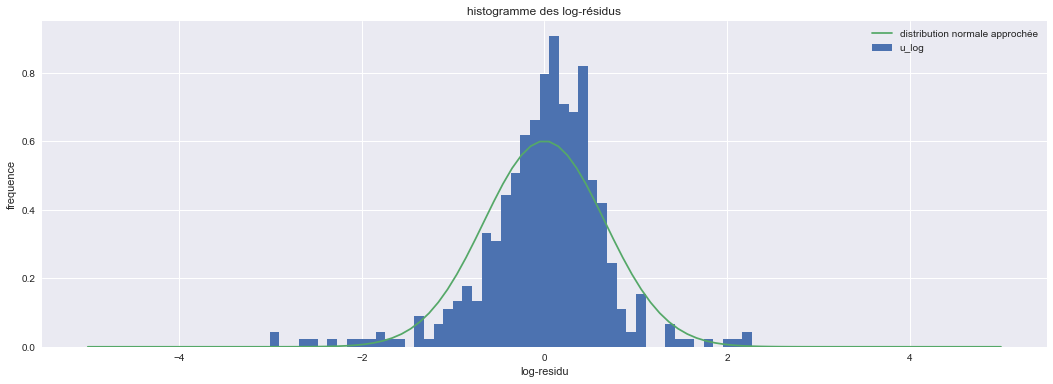

In [29]:
mu_u_log, std_u_log = norm.fit(u_log)
x = np.linspace(-5, 5, 100)
distrib_log = norm.pdf(x, mu_u_log, std_u_log)

fig, axes = plt.subplots(nrows=1, ncols=1,  figsize=(18, 6))
plt.hist(u_log, normed=True, bins=50, label='u_log')
plt.plot(x, distrib_log, label='distribution normale approchée')
plt.title('histogramme des log-résidus')
plt.xlabel('log-residu')
plt.ylabel('frequence')
plt.legend(loc='upper right')

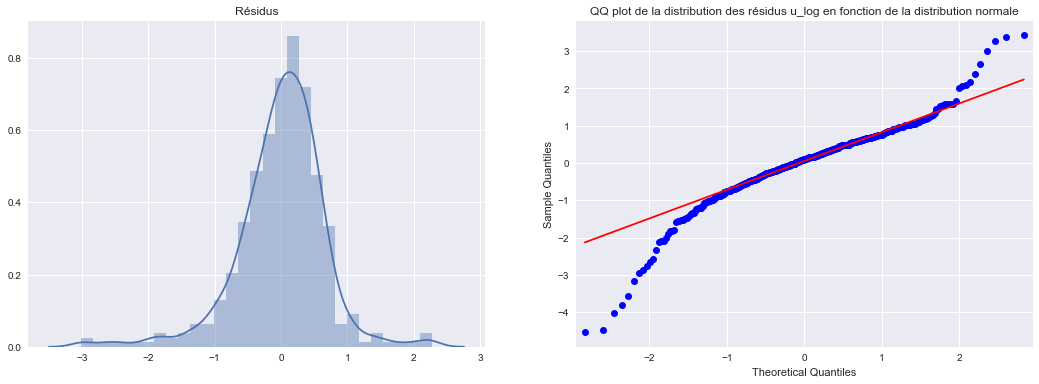

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(18, 6))
sns.distplot(u_log, ax=axes[0])
u_log_qqplot = list(u_log)
u_log_qqplot.sort()
u_log_qqplot = np.array(u_log_qqplot)
qqplot(u_log_qqplot, line='q', fit=True, ax=axes[1])

axes[0].title.set_text('Résidus')
axes[1].title.set_text(
    'QQ plot de la distribution des résidus u_log en fonction de la distribution normale')
plt.show()

On remarque que les distribution de résidus de la régression linéaire de lwage suivent mieux une distribution normale.
Ce qui est meilleur pour les tests statistiques.

### 9- Tester l'hypothèse de non significativité de exper avec un seuil de significativité de 1%, 5% et 10% (test alternatif des deux côtés). Commentez les p-values.

Pour tester cette hypothèse nous allons faire un test de Student sur la variable exper.

In [31]:
array_ = np.array(
    df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']])
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_log = np.dot(mat_X, y_lwage)
u_log = y_lwage - np.dot(X, beta_log)

# Calcul de la standard deviation
sig2_log = np.dot(u_log.T, u_log) / (n - k)
std_log = np.sqrt(np.diag(sig2_log * inv_gram_X))
print(std_log)

(428, 7)
[0.20705047 0.07017832 0.01510178 0.004487   0.00333073 0.08530773
 0.02694439]


In [32]:
t_log = beta_log[3] / std_log[3]
print("Nous avons donc une t-statistique associée à la variable exper de {}".format(t_log[0]))

Nous avons donc une t-statistique associée à la variable exper de 3.4517180575592707


In [33]:
p_value = sp.stats.t.ppf(0.95, n - k)
print(p_value)

1.6484810571255268


In [34]:
p_value = sp.stats.t.ppf(0.975, n - k)
print(p_value)

1.965614792008086


In [35]:
p_value = sp.stats.t.ppf(0.995, n - k)
print(p_value)

2.5875575730543354


On remarque que la variable t_log est supérieure à tous les p-values des tests à 10%, 5% et 1%.
Les tests de non-significativité de expr à des significativité à 10%, 5% et 1% sont donc rejetés.

### 10- Tester l’hypothèse que le coefficient associé à educ est égal à 10% avec un seuil de significativité de 5% (test à alternatif des deux côtés)

In [36]:
t_log = (beta_log[2] - 0.1) / std_log[2]
print(
    "Nous avons donc une t-statistique associée à la variable educ de {}".format(t_log[0]))

Nous avons donc une t-statistique associée à la variable educ de 0.14882589437781713


In [37]:
p_value = sp.stats.t.ppf(0.975, n - k)
print(p_value)

1.965614792008086


Le test du coefficient à 10% avec un seuil de significativité de 5% est accepté.

### 11- Tester l’hypothèse jointe que le rendement de l’éducation est de 10% et que celui de l’expérience professionnelle est de 5%.

Pour cela nous allons faire un test de Fisher avec $y^{*} = y - 0.1*educ - 0.05 * exper $ et $H_{0}: \beta_{educ} = 0$ et $\beta_{exper} = 0 $.

In [38]:
# Modèle NC
y_joint = y_lwage - 0.1 * df_mroz['educ'].reshape(-1, 1) - 0.05 * df_mroz['exper'].reshape(-1, 1)
array_ = np.array(
    df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']])

X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_joint = np.dot(mat_X, y_joint)
print(beta_joint)
residu_NC = y_joint - np.dot(X, beta_joint)
SSR_NC = np.dot(residu_NC.T, residu_NC)

# Modèle Contraint (coeff des 'educ', 'exper' à 0)
array_C = np.array(df_mroz[['city', 'nwifeinc', 'kidslt6', 'kidsge6']])
X_C = np.hstack((np.ones((n, 1)), array_C))

gram_X_C = np.dot(X_C.T, X_C)
inv_gram_X_C = np.linalg.inv(gram_X_C)
mat_X_C = np.dot(inv_gram_X_C, X_C.T)
beta = np.dot(mat_X_C, y_joint)

residu_C = y_joint - np.dot(X_C, beta)
SSR_C = np.dot(residu_C.T, residu_C)

q = 2  # nombre de variables dont on test
F_stat = ((SSR_C - SSR_NC) / q) / (SSR_NC / (n - (k)))
print("Nous avons donc une F-statistique de {}".format(F_stat[0, 0]))

(428, 7)
[[-0.3989751 ]
 [ 0.03526789]
 [ 0.00224754]
 [-0.03451213]
 [ 0.0048827 ]
 [-0.04530286]
 [-0.01170351]]
Nous avons donc une F-statistique de 29.580755900389306


In [39]:
# sc.stats.f.sf pour les test de Fischer ( t est pour les tests de Students)
p_value = sp.stats.f.sf(F_stat, q, n - k)
print(p_value)

[[9.53553253e-13]]


L'aire au-delà de la F-statistique étant bien inférieure à 1%, l'hypothèse jointe que le rendement de l’éducation est de 10% et que celui de l’expérience professionnelle est de 5% et ceux à une significativité de 5% est refusée.

### 12- De combien augmente le salaire en pourcentage avec 10 années d’expérience ?

In [40]:
array_ = np.array(
    df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']])
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_log = np.dot(mat_X, y_lwage)
u_log = y_lwage - np.dot(X, beta_log)

(428, 7)


$log(wage) = \beta_{0} + \beta_{educ} * educ + \beta_{exper} *exper + \beta_{city} * city + \beta_{nwifeinc} * nwifeinc + \beta_{kidslt6} * kidslt6 + \beta_{kidsge6} * kidsge6$

$wage = e^{\beta_{exper} * exper} * e^{\beta_{0} + \beta_{educ} * educ +\beta_{city} * city + \beta_{nwifeinc} * nwifeinc + \beta_{kidslt6} * kidslt6 + \beta_{kidsge6} * kidsge6}$


$wage_{10ans} = e^{\beta_{exper} * (exper+10)} * e^{\beta_{0} + \beta_{educ} * educ +\beta_{city} * city + \beta_{nwifeinc} * nwifeinc + \beta_{kidslt6} * kidslt6 + \beta_{kidsge6} * kidsge6}$


$poucentage_{10ans} = (wage_{10ans} - wage) / wage$

$poucentage_{10ans} = e^{\beta_{exper} * 10} - 1$

In [41]:
pourcentage = np.exp((beta_log[3] * 10)) - 1
print("Avec notre modèle, le poucentage de gain de salaire au bout de 10 ans est donc de: {}".format(pourcentage[0]))

Avec notre modèle, le poucentage de gain de salaire au bout de 10 ans est donc de: 0.16751634220298395


Le salaire augmente de 16,75%.

### 13- Tester l’égalité des coefficients associés aux variables kidsge6 et kidslt6. Interprétez.

In [42]:
array_ = np.array(df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6']])
kid_age = df_mroz['kidslt6'] + df_mroz['kidsge6']
kid_age = kid_age.reshape(-1, 1)
array_ = np.hstack((array_, kid_age))
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_log = np.dot(mat_X, y_lwage)
u_log = y_lwage - np.dot(X, beta_log)

# Calcul de la standard deviation
sig2_log = np.dot(u_log.T, u_log) / (n - k)
std_log = np.sqrt(np.diag(sig2_log * inv_gram_X))
# print(std_log)

t_log = (beta_log[5]) / std_log[5]
print('Valeur de la t-statistique: %s' % t_log[0])
p_value = sp.stats.t.ppf(0.975, n - k)
print('Valeur de la p-value à 5% de significativité en test des 2 côtés: {}'.format(p_value))

p_value = sp.stats.t.ppf(0.95, n - k)
print('Valeur de la p-value à 10% de significativité en test des 2 côtés: {}'.format(p_value))

(428, 7)
Valeur de la t-statistique: -0.3717472501996224
Valeur de la p-value à 5% de significativité en test des 2 côtés: 1.965614792008086
Valeur de la p-value à 10% de significativité en test des 2 côtés: 1.6484810571255268


L'hypothèse d'égalité des coefficients associés aux variables kidsge6 et kidslt6 n'est donc pas rejetée à 10% et 5%.

### 14- En utilisant le modèle de la question 7, faire le test d'hétéroscédasticité de forme linéaire en donnant la p-valeur. Corriger le problème par rapport à la variable la plus importante en utilisant la méthode des MCG. Comparer les écarts-types des coefficients estimés avec ceux obtenus à la question 7. Commenter.

In [43]:
array_ = np.array(
    df_mroz[['city', 'educ', 'exper', 'nwifeinc', 'kidslt6', 'kidsge6']])
y_wage = np.array(df_mroz['wage']).reshape(-1, 1)
n, k = array_.shape
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
# print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_wage = np.dot(mat_X, y_wage)
u = y_wage - np.dot(X, beta_wage)

# Regression de u_squared
df_u = pd.DataFrame(u)
u_squared = df_u.apply(lambda x: x**2)
y_squared = u_squared

n, k = array_.shape
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_u = np.dot(mat_X, y_squared)

residu_u_squared_NC = y_squared - np.dot(X, beta_u)
SSR_NC = np.dot(residu_u_squared_NC.T, residu_u_squared_NC)

# Modèle Contraint (tous les coefficients des variables à 0)
X_C = np.ones((n, 1))

gram_X_C = np.dot(X_C.T, X_C)
inv_gram_X_C = np.linalg.inv(gram_X_C)
mat_X_C = np.dot(inv_gram_X_C, X_C.T)
beta = np.dot(mat_X_C, y_squared)

residu_u_squared_C = y_squared - np.dot(X_C, beta)
SSR_C = np.dot(residu_u_squared_C.T, residu_u_squared_C)

q = 6  # nombre de variables dont on test
F_stat = ((SSR_C - SSR_NC) / q) / (SSR_NC / (n - (k)))
print("Nous avons donc une F-statistique de {}".format(F_stat[0, 0]))

(428, 7)
Nous avons donc une F-statistique de 1.5926181620172075


In [44]:
# sc.stats.f.sf pour les test de Fischer ( t est pour les tests de Students)
p_value = sp.stats.f.sf(F_stat, q, n - k)
print(
    "Nous avons donc une aire au-delà de la F_stat de {}".format(p_value[0, 0]))

Nous avons donc une aire au-delà de la F_stat de 0.14766133314493152


Le test d'homoscédasticité étant à une significativité de 5%.
Nous avons donc notre hypothèse $H_{0}$: Le modèle est homoscédastique qui n'est pas rejeté.
Nous allons maintenant procéder à une régression des moindres carrés généralisés afin d'avoir une hypothèse d'homoscédasticité plus robuste. Nous allons utiliser le système des MCG vis-à-vis de la variable la plus importante. 

In [45]:
# Pour Rappel
print(beta_wage)

[[-2.40345399]
 [ 0.36975203]
 [ 0.4600477 ]
 [ 0.02381995]
 [ 0.01524479]
 [ 0.03617319]
 [-0.06189091]]


Notre variable ayant le plus grand $\beta$ est educ. C'est donc la variable la plus importante.

In [46]:
y_wage_rect = np.divide(
    np.array(df_mroz['wage']), np.array(np.sqrt(df_mroz['educ'])))

arr_ho = np.array(df_mroz[['city', 'educ', 'exper', 'nwifeinc',
                           'kidslt6', 'kidsge6']]) / np.sqrt(df_mroz['educ']).reshape(-1, 1)

X_MCG = np.hstack(
    (np.ones((n, 1)) / np.sqrt(df_mroz['educ']).reshape(-1, 1), arr_ho))


n, k = X_MCG.shape
print(X_MCG.shape)

gram_X_MCG = np.dot(X_MCG.T, X_MCG)
inv_gram_X_MCG = np.linalg.inv(gram_X_MCG)
mat_X_MCG = np.dot(inv_gram_X_MCG, X_MCG.T)

beta_MCG = np.dot(mat_X_MCG, y_wage_rect)
u = y_wage_rect - np.dot(X_MCG, beta_MCG)
sig2_MCG = u.T@u / (n - k)
std_MCG = np.sqrt(np.diag(sig2_MCG * inv_gram_X_MCG))

df_u = pd.DataFrame(u)

u_squared = df_u.apply(lambda x: x**2)
y_squared = u_squared

# Modèle NC
beta = np.dot(mat_X_MCG, y_squared)
residu_u_squared_NC = y_squared - np.dot(X_MCG, beta)
SSR_NC = np.dot(residu_u_squared_NC.T, residu_u_squared_NC)

# Modèle Contraint (tous les coefficients à 0)
X_C = np.ones((n, 1)) / np.sqrt(df_mroz['educ']).reshape(-1, 1)
gram_X_C = np.dot(X_C.T, X_C)
inv_gram_X_C = np.linalg.inv(gram_X_C)
mat_X_C = inv_gram_X_C * X_C.T
beta = np.dot(mat_X_C, y_squared)
residu_u_squared_C = y_squared - np.dot(X_C, beta)
SSR_C = np.dot(residu_u_squared_C.T, residu_u_squared_C)

q = 6  # nombre de variables
F_stat = ((SSR_C - SSR_NC) / q) / (SSR_NC / (n - (k)))
print("Nous avons donc une F-statistique de {}".format(F_stat[0, 0]))

(428, 7)
Nous avons donc une F-statistique de 1.4572446625540032


In [47]:
# sc.stats.f.sf pour les test de Fischer ( t est pour les tests de Students)
p_value = sp.stats.f.sf(F_stat, q, n - k)
print(
    "Nous avons donc une aire au-delà de la F_stat de {}".format(p_value[0, 0]))

Nous avons donc une aire au-delà de la F_stat de 0.19147835700229163


Nous remarquons que nous avons une plus faible variable de Fisher ce qui se traduit par une plus grande aire au-delà de la courbe.
Nous avons donc notre hypothèse $H_{0}$: Le modèle est homoscédastique qui n'est pas rejeté et ce avec plus significativité.

In [48]:
print("La standard deviation des coefficients de la MCO sont: {}.".format(std_MCO))
print("La standard deviation des coefficients de la MCG sont: {}.".format(std_MCG))

La standard deviation des coefficients de la MCO sont: [0.96349591 0.32657023 0.07027516 0.02087998 0.01549936 0.39697399
 0.12538399].
La standard deviation des coefficients de la MCG sont: [0.88922322 0.31412513 0.06631588 0.02009794 0.01548682 0.39889659
 0.11960991].


Nous avons donc les écarts-types des coefficients de $\beta_{MCG}$ qui sont plus faibles que ceux des coefficients de $\beta_{MCO}$ 

### 15- Tester le changement de structure de la question 8 entre les femmes qui ont plus de 43 ans et les autres : test sur l'ensemble des coefficients. Refaire le test avec 3 groupes (mutuellement exclusifs) : les femmes de moins de 30 ans, entre 30 et 43 ans, plus de 43 ans. Donnez les p-valeurs

In [49]:
print("Nous avons %s femmes dont l'âge est supérieur à 43 ans."% df_mroz[df_mroz['age']>43].shape[0])
print("Nous avons %s femmes dont l'âge est inférieur à 43 ans."% df_mroz[df_mroz['age']<43].shape[0])

Nous avons 186 femmes dont l'âge est supérieur à 43 ans.
Nous avons 217 femmes dont l'âge est inférieur à 43 ans.


Nous avons 2 manières de procéder : 
    - créer 2 datasets différents (un dataset contant les femmes ayant moins de 43 ans et un contenant les femmes de plus de 43 ans) et calculer la Fisher entre 2 groupes.
    - créer 6 variables d'intéractions et procéder à un test de Fisher sur l'hypothèse H0 qu'elles n'ont pas d'effets significatifs.

Nous allons procéder selon la 2 manière pour tester ce changement de structure.

In [50]:
# Creation des variables d'interaction
const_over_43 = np.zeros((df_mroz.shape[0], 1))
const_over_43[df_mroz['age'] > 43] = 1
df_over_43 = df_mroz[['city', 'educ', 'exper', 'nwifeinc',
                      'kidslt6', 'kidsge6']].where(df_mroz['age'] > 43, other=0)
array_df = np.hstack((const_over_43, np.array(df_over_43)))
n, k = array_df.shape

array_ = np.hstack((np.ones((n, 1)), np.array(df_mroz[['city', 'educ', 'exper', 'nwifeinc',
                                                       'kidslt6', 'kidsge6']])))

X_over_43 = np.hstack((array_, array_df))
n, k = X_over_43.shape
print(X_over_43.shape)
gram_X_over_43 = np.dot(X_over_43.T, X_over_43)
inv_gram_X_over_43 = np.linalg.inv(gram_X_over_43)
mat_X_over_43 = np.dot(inv_gram_X_over_43, X_over_43.T)
beta_over_43_NC = np.dot(mat_X_over_43, y_lwage)
u_NC = y_lwage - np.dot(X_over_43, beta_over_43_NC)
SSR_NC = np.dot(u_NC.T, u_NC)
# Modèle Contraint (tous les coefficients des variables d'interaction à 0)
X_C = array_

gram_X_C = np.dot(X_C.T, X_C)
inv_gram_X_C = np.linalg.inv(gram_X_C)
mat_X_C = np.dot(inv_gram_X_C, X_C.T)
beta_C = np.dot(mat_X_C, y_lwage)

u_C = y_lwage - np.dot(X_C, beta_C)
SSR_C = np.dot(u_C.T, u_C)

q = 7  # nombre de variables dont on test
F_stat = ((SSR_C - SSR_NC) / q) / (SSR_NC / (n - (k)))
print("Nous avons donc une F-statistique de {}".format(F_stat[0, 0]))

(428, 14)
Nous avons donc une F-statistique de 0.8260377871071967


In [51]:
# sc.stats.f.sf pour les test de Fischer ( t est pour les tests de Students)
p_value = sp.stats.f.sf(F_stat, q, n - k)
print(
    "Nous avons donc une aire au-delà de la F_stat de {}".format(p_value[0, 0]))

Nous avons donc une aire au-delà de la F_stat de 0.5660361961109819


Notre hypothèse H0 n'est donc pas rejetée. Le changement de structure n'est donc pas significatif.

In [52]:
print("Nous avons %s femmes dont l'âge est supérieur à 43 ans." %
      df_mroz[df_mroz['age'] > 43].shape[0])
print("Nous avons %s femmes dont l'âge est inférieur à 30 ans." %
      df_mroz[df_mroz['age'] < 30].shape[0])
print("Nous avons %s femmes dont l'âge est entre 30 et 43 ans." % (
    df_mroz[df_mroz['age'] <= 43].shape[0] - df_mroz[df_mroz['age'] < 30].shape[0]))

Nous avons 186 femmes dont l'âge est supérieur à 43 ans.
Nous avons 0 femmes dont l'âge est inférieur à 30 ans.
Nous avons 242 femmes dont l'âge est entre 30 et 43 ans.


Comme nous n'avons pas d'échantillons représentant la catégorie d'âge en dessous de 30 ans, il n'est pas possible d'étudier ce changement de structure.

### 16- A partir de la variable kidslt6, créer un ensemble de variables binaires pour le nombre d’enfants de moins de 6 ans. Refaire la question 8 avec ces variables et en utilisant comme référence les femmes qui ont des enfants de plus de 6 ans. Ces catégories sont-elles mutuellement exclusives ? Interprétez les paramètres associés aux variables binaires. Faire le test de non significativité de l’ensemble des variables binaires. Donnez les p-valeurs

In [53]:
print(np.unique(df_mroz['kidslt6']))

[0 1 2]


Les femmes échantillonées ont donc 0, 1 ou 2 enfants en dessous de l'âge de 6 ans.

On ne peut pas prendre en référence la colonne des femmes ayant des enfants de plus de 6 ans car elles sont non mutuellement exclusives. 

Nous allons donc  procéder à la création des variables binaires 1_kidslt6 (associé au qu'une femme a ou non 1 enfant de moins de 6 ans) et 2_kidslt6. Nous prennons alors en référence la variable 0_kidslt6 liée à l'absence ou non d'un enfant de moins de 6 ans.

In [54]:
df_kidslt6 = df_mroz[['lwage', 'city', 'educ', 'exper', 'nwifeinc', 'kidsge6']]
#array_ = np.array(df_kidslt6)
arr_1_kidslt6 = np.zeros((df_mroz.shape[0], 1))
arr_1_kidslt6[df_mroz['kidslt6'] == 1] = 1
arr_2_kidslt6 = np.zeros((df_mroz.shape[0], 1))
arr_2_kidslt6[df_mroz['kidslt6'] == 2] = 1
df_kidslt6['_1_kidslt6'] = arr_1_kidslt6
df_kidslt6['_2_kidslt6'] = arr_2_kidslt6
#array_ = np.hstack((df_kidslt6, arr_1_kidslt6, arr_2_kidslt6))
df_kidslt6.head()

,lwage,city,educ,exper,nwifeinc,kidsge6,_1_kidslt6,_2_kidslt6
0,1.210154,0,12,14,10.910060,0,1.0,0.0
1,0.328512,1,12,5,19.499980,2,0.0,0.0
2,1.514138,0,12,15,12.039910,3,1.0,0.0
3,0.092123,0,12,6,6.799996,3,0.0,0.0
4,1.524272,1,14,7,20.100060,2,1.0,0.0


In [55]:
df_kidslt6 = df_kidslt6[['city', 'educ', 'exper',
                         'nwifeinc', 'kidsge6', '_1_kidslt6', '_2_kidslt6']]
print(df_kidslt6.head())
array_ = np.array(df_kidslt6)

n, k = array_.shape
X = np.hstack((np.ones((n, 1)), array_))
n, k = X.shape
print(X.shape)
gram_X = np.dot(X.T, X)
inv_gram_X = np.linalg.inv(gram_X)
mat_X = np.dot(inv_gram_X, X.T)
beta_lwage_kidslt6 = np.dot(mat_X, y_lwage)
u_log_kidslt6 = y_lwage - np.dot(X, beta_lwage_kidslt6)

   city  educ  exper   nwifeinc  kidsge6  _1_kidslt6  _2_kidslt6
0     0    12     14  10.910060        0         1.0         0.0
1     1    12      5  19.499980        2         0.0         0.0
2     0    12     15  12.039910        3         1.0         0.0
3     0    12      6   6.799996        3         0.0         0.0
4     1    14      7  20.100060        2         1.0         0.0
(428, 8)


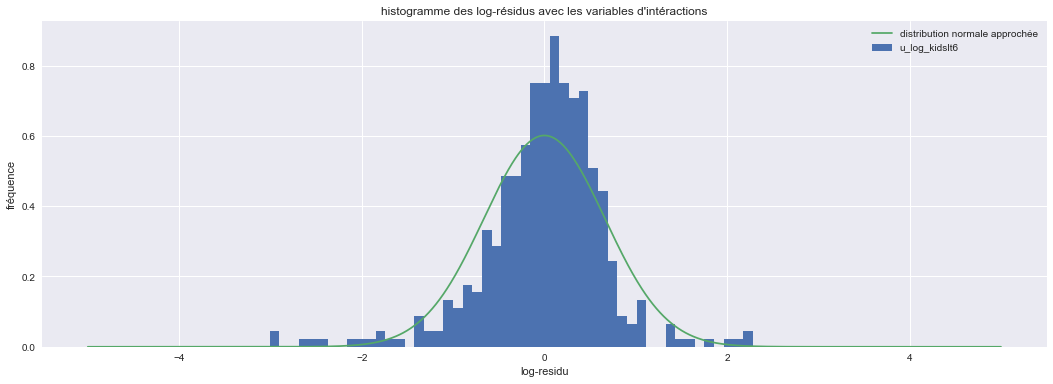

In [56]:
mu_u_log_kidslt6, std_u_log_kidslt6 = norm.fit(u_log_kidslt6)
x = np.linspace(-5, 5, 1000)
distrib_log_kidslt6 = norm.pdf(x, mu_u_log_kidslt6, std_u_log_kidslt6)

fig, axes = plt.subplots(nrows=1, ncols=1,  figsize=(18, 6))
plt.hist(u_log_kidslt6, normed=True, bins=50, label='u_log_kidslt6')
plt.plot(x, distrib_log_kidslt6, label='distribution normale approchée')
plt.title("histogramme des log-résidus avec les variables d'intéractions")
plt.xlabel('log-residu')
plt.ylabel('fréquence')
plt.legend(loc='upper right')

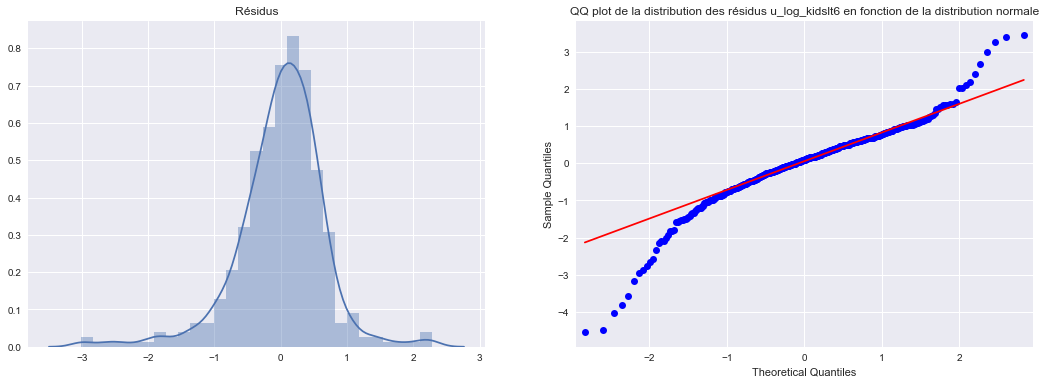

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(18, 6))
sns.distplot(u_log_kidslt6, ax=axes[0])
u_log_qqplot = list(u_log_kidslt6)
u_log_qqplot.sort()
u_log_qqplot = np.array(u_log_qqplot)
qqplot(u_log_qqplot, line='q', fit=True, ax=axes[1])

axes[0].title.set_text('Résidus')
axes[1].title.set_text(
    'QQ plot de la distribution des résidus u_log_kidslt6 en fonction de la distribution normale')
plt.show()

On remarque que la distribution de résidus de la régression linéaire de lwage avec les variables binaires suivent aussi bien la distribution normale.
Que ceux de la régression linéaire de lwage.


In [58]:
print(beta_lwage_kidslt6)

[[-0.39755039]
 [ 0.03460918]
 [ 0.10221938]
 [ 0.01543688]
 [ 0.00490326]
 [-0.01159373]
 [-0.05402964]
 [-0.06502802]]


On remarque que les paramètres $\beta$ associés aux variables binaires sont négatifs. Ceci indique qu'avoir 1 ou 2 enfants de moins de 6 ans a un impact plus négatif que de ne pas avoir d'enfant de moins de 6 ans. Cependant, nous remarquons que ces coefficients sont proches de 0. Nous allons alors faire un teste de non-significativité.

Nous allons maintenant procéder au test statistique sur l'hypothèse $H_{0}$: la variable _1_kidslt6 n'est pas significative.
Puis, nous ferons un test sur la significativité de _2_kidslt6.

In [59]:
# Calcul de la standard deviation
sig2_log_kidslt6 = np.dot(u_log_kidslt6.T, u_log_kidslt6) / (n - k)
std_log_kidslt6 = np.sqrt(np.diag(sig2_log_kidslt6 * inv_gram_X))
print(std_log)

t_log_1kidslt6 = (beta_lwage_kidslt6[6]) / std_log_kidslt6[6]
print('Valeur de la t-statistique: {}'.format(t_log_1kidslt6))

t_log_2kidslt6 = (beta_lwage_kidslt6[7]) / std_log_kidslt6[7]
print('Valeur de la t-statistique: {}'.format(t_log_2kidslt6))

p_value = sp.stats.t.ppf(0.95, n-k)
print('Valeur de la p-value à 5% de significativité: {}'.format(p_value))

[0.20705047 0.07017832 0.01510178 0.004487   0.00333073 0.09038225
 0.02694439]
Valeur de la t-statistique: [-0.49994056]
Valeur de la t-statistique: [-0.25151058]
Valeur de la p-value à 5% de significativité: 1.648489713050696


Nous avons donc des variables t inférieures à la p_value. Les hypothèse de non significativité ne sont donc pas refusés à 5%. Avoir 1 ou 2 enfants de moins de 6 ans n'est respectivement pas significatif par rapport à avoir aucun enfant de moins de 6 ans

Nous allons maintenant faire l'hypothèse jointe $H_{0}$ : qu'avoir 1 ou 2 enfants de moins de 6 ans n'est pas significatif par rapport à avoir aucun enfant de moins de 6 ans.

In [60]:
SSR_NC = np.dot(u_log_kidslt6.T, u_log_kidslt6)
# Modèle Contraint (tous les coefficients des variables binaires à 0)
df_kidslt6 = df_kidslt6[['city', 'educ', 'exper', 'nwifeinc', 'kidsge6']]
array_ = np.array(df_kidslt6)
X_C = np.hstack((np.ones((n, 1)), array_))

gram_X_C = np.dot(X_C.T, X_C)
inv_gram_X_C = np.linalg.inv(gram_X_C)
mat_X_C = np.dot(inv_gram_X_C, X_C.T)
beta_C = np.dot(mat_X_C, y_lwage)

u_C = y_lwage - np.dot(X_C, beta_C)
SSR_C = np.dot(u_C.T, u_C)

q = 7  # nombre de variables dont on test
F_stat = ((SSR_C - SSR_NC) / q) / (SSR_NC / (n - (k)))
print("Nous avons donc une F-statistique de {}".format(F_stat[0, 0]))

Nous avons donc une F-statistique de 0.04267501949422629


In [61]:
# sc.stats.f.sf pour les test de Fischer ( t est pour les tests de Students)
p_value = sp.stats.f.sf(F_stat, q, n - k)
print(
    "Nous avons donc une aire au-delà de la F_stat de {}".format(p_value[0, 0]))

Nous avons donc une aire au-delà de la F_stat de 0.9998995182483096


Nous ne pouvons donc pas refuser l'hypothèse $H_{0}$ avec une sginificativité de 5%.

## Partie 2: Series Temporelles 

In [62]:
def compute_AIC(residual, X):
    sigma2 = np.dot(np.transpose(residual),residual) / (X.shape[0]-X.shape[1])
    return np.log(sigma2) + 2*(X.shape[1]-1)/X.shape[0]

In [63]:
def compute_OLS(X,y):
    """return beta and residual"""
    beta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),y)
    residual = y - np.dot(X,beta)
    return beta, residual

In [64]:
def compute_Fisher(X,y,beta,beta_restricted,val_fixed):
    """return F-stat & p-value"""
    #compute ssr
    ssr_r = np.sum((y - np.dot(X,beta_restricted))**2)
    ssr_ur = np.sum((y - np.dot(X,beta))**2)
    
    #compute degre liberté
    df_r = y.shape[0] - len(beta)-1-val_fixed
    df_ur = y.shape[0] - len(beta)-1
    dl_num = df_ur-df_r
    
    #compute F-stats
    F_stat_exper = ((ssr_r-ssr_ur)/dl_num)/(ssr_ur/df_ur)
    
    return F_stat_exper,1 - sp.stats.f.cdf(F_stat_exper, dl_num, df_ur)

#### 1) Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)

In [65]:
quaterly_raw = pd.read_excel('quarterly.xls')
quaterly_raw.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


In [66]:
#valeurs manquantes ?
quaterly_raw.isnull().sum(axis=0)

DATE        0
FFR         0
Tbill       0
Tb1yr       0
r5          0
r10         0
PPINSA      0
Finished    0
CPI         0
CPICORE     0
M1NSA       0
M2SA        0
M2NSA       0
Unemp       0
IndProd     0
RGDP        0
Potent      0
Deflator    0
Curr        0
dtype: int64

In [67]:
quaterly_raw.set_index("DATE",inplace=True)
quaterly_raw.head()

,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
DATE,,,,,,,,,,,,,,,,,,
1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


#### 2) Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.

In [68]:
inf = np.zeros(quaterly_raw['CPI'].shape[0]-1)
for i,elt in enumerate(quaterly_raw['CPI']):
    if i<quaterly_raw['CPI'].shape[0]-1:
        inf[i] = 100*((quaterly_raw['CPI'][i+1] - quaterly_raw['CPI'][i]) / quaterly_raw['CPI'][i])

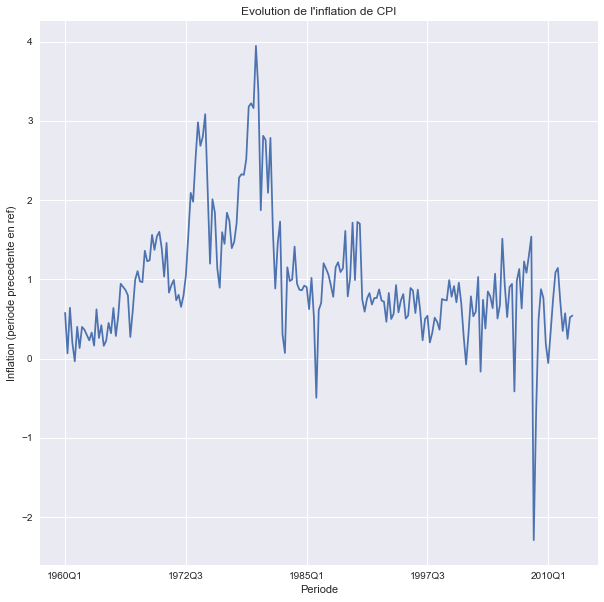

In [69]:
#plot evolution taux d'inflation
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(inf)
ax.set_title("Evolution de l'inflation de CPI")
ax.set_xlabel("Periode")
ax.set_ylabel("Inflation (periode precedente en ref)")
plt.xticks([0,50,100,150,200],[quaterly_raw.index.tolist()[i] for i in [0,50,100,150,200]])
fig.show()

On est sur une tendance croissante jusqu'avant 1985, puis il y a une chute brutale menant sur une tendance plutot constante. Au vue du changement de tendance et des variations irrégulières, les propriétés statistiques de la série : moyenne, variance ne sont pas constante quelque soit les périodes observées, elle ne serait pas stationnaire.


#### 3) Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ?

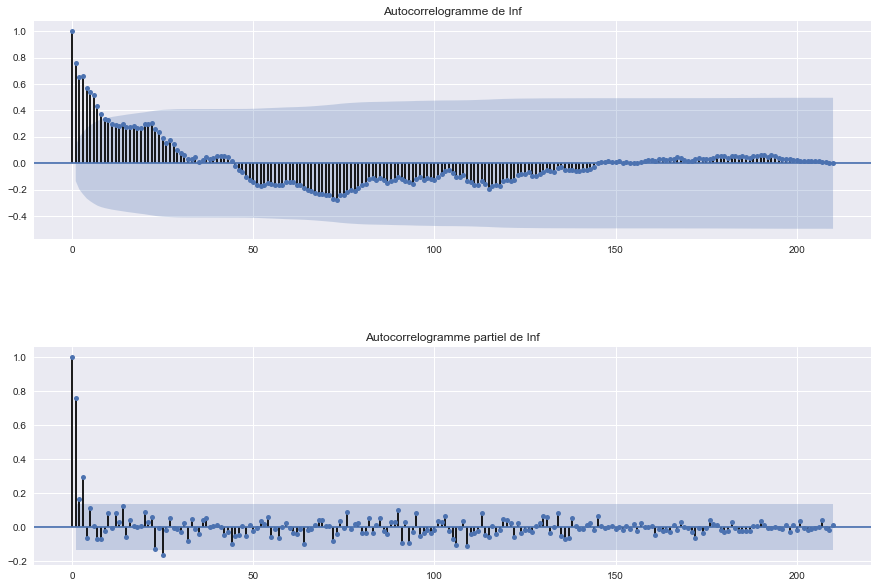

In [70]:
import pylab as pl
import statsmodels.api as sm
fig, axes = pl.subplots(2,1, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
fig=sm.graphics.tsa.plot_acf(inf,ax=axes[0])
axes[0].set_title("Autocorrelogramme de Inf")
fig=sm.graphics.tsa.plot_pacf(inf, ax=axes[1])
axes[1].set_title("Autocorrelogramme partiel de Inf")
plt.show()

L'ACF mesure à quel point une série est corrélée à ses différents lags : corrélation entre l'instant t et le retard d'ordre k (t-k). 

La PACF mesure la corrélation partielle entre la série et ses lags, partielle, car on observe la corrélation d'ordre k entre z_t et z_t-k en retirant la corrélation induite par la propagation des corrélations entre lags de petits ordres. En effet la corrélation d'ordre 1 entre z_t et z_t-1 prend part dans la corrélation d'ordre k entre z_t et z_t-k par effet de propagation.
Ainsi la PACF nous indique que si un petit nombre p de coefficients partiels sont plus siginficatis que ceux d'ordre supérieur alors les AR d'ordre supérieur à p sont majoritairement expliqué par l'AR(p).

On utilise ces deux fonctions pour décider de la modélisation à adopter : AR, MA, ARMA :
    - MA : PACF decroissante et nb de retards avec ACF
    - AR : ACF decroissante et nb de retards avec PACF
    - ARMA : aucun des deux comportements précédents

#### 4) Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

Avant de proposer une modélisation intéressons nous à la stationnarité de la série

In [71]:
#create lags
inf1 = np.zeros(inf.shape[0]-5)
inf2 = np.zeros(inf.shape[0]-5)
inf3 = np.zeros(inf.shape[0]-5)
inf4 = np.zeros(inf.shape[0]-5)

inf1 = inf[4:-1]
inf2 = inf[3:-2]
inf3 = inf[2:-3]
inf4 = inf[1:-4]
inf5 = inf[:-5]
inf = inf[5:]

In [72]:
import statsmodels.tsa.stattools as ts

unit_test = ts.adfuller(inf, regression="ct", autolag = 'AIC')
print("test stats: {0}".format(unit_test[0]))
print("p-value: {0}".format(unit_test[1]))
print('Critical Values:')
for key, value in unit_test[4].items():
    print('\t%s: %.3f' % (key, value))

test stats: -3.28842390705868
p-value: 0.06817754623869363
Critical Values:
	1%: -4.004
	5%: -3.432
	10%: -3.140


$y_t = \alpha + \rho*y_{t-1} +e_t $ 

H0 : la série possède une racine unitaire $\rho=1 $ , elle est non stationnaire 

On ne rejette pas H0 avec un risque de première espace à 10% et 5% (test unilatéral cas $\rho>1 $ non considéré) : la série possède  une racine unitaire, elle est donc non stationnaire. Essayons de nouveau en différenciant la série

In [73]:
import statsmodels.tsa.stattools as ts

unit_test = ts.adfuller(inf-inf1, regression="ct", autolag = 'AIC')
print("test stats: {0}".format(unit_test[0]))
print("p-value: {0}".format(unit_test[1]))
print("lag: {0}".format(unit_test[2]))
print('Critical Values:')
for key, value in unit_test[4].items():
    print('\t%s: %.3f' % (key, value))

test stats: -9.80652577895252
p-value: 5.975767140925475e-15
lag: 3
Critical Values:
	1%: -4.004
	5%: -3.432
	10%: -3.140


On rejette H0 à 1% la série différenciée inf-inf1 n'a pas de racine unitaire, on en déduit que la série différenciée est stationnaire. Le modèle propose un modèle à trois lags : AR(3)

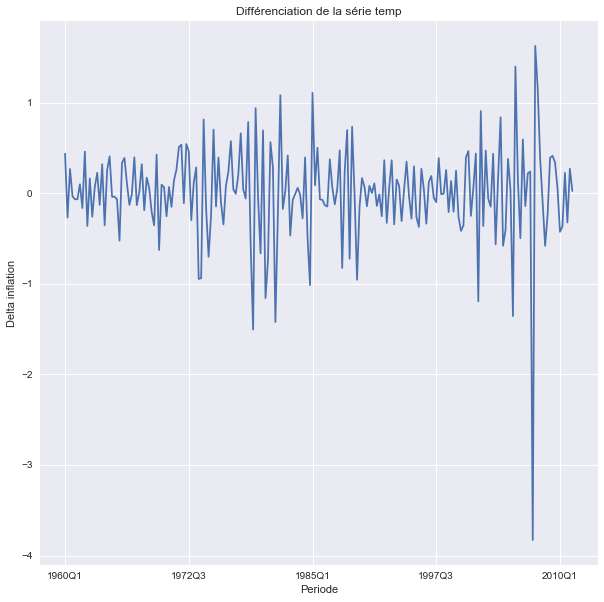

In [74]:
#plot evolution taux d'inflation
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(inf-inf1)
ax.set_title("Différenciation de la série temp")
ax.set_xlabel("Periode")
ax.set_ylabel("Delta inflation")
plt.xticks([0,50,100,150,200],[quaterly_raw.index.tolist()[i] for i in [0,50,100,150,200]])
fig.show()

Au vue des courbes ACF et PACF, l'intuition est de partir sur une modélisation avec 3 retards maximum. Il semblerait qu'une AR(3) puisse convenir c'est le dernier qui a une corr partielle au dessus de 0.2. Vérifions ces intuitions avec le calcul de l'AIC pour AR(1), AR(2), AR(3), AR(4).

#### 5) Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation et une constante.

On considère ici un modèle simple sans lag sur le taux d'inflation, il faut au préalable stationariser la serie unemp. On utilisera les deux séries stationnarisées : unemp et inflation

In [75]:
y_unemp = quaterly_raw['Unemp'][6:].values

In [76]:
#test stationnariser unemp
unit_test = ts.adfuller(y_unemp, regression="ct", autolag = 'AIC')
print("test stats: {0}".format(unit_test[0]))
print("p-value: {0}".format(unit_test[1]))
print('Critical Values:')
for key, value in unit_test[4].items():
    print('\t%s: %.3f' % (key, value))

test stats: -2.663433763171082
p-value: 0.25157654645202165
Critical Values:
	1%: -4.006
	5%: -3.433
	10%: -3.140


On ne rejette pas H0 la serie temporelle unemp n'est pas stationnaire à 10%. Essayons de la différencier.

In [77]:
#X_inf y_unemp def
X_inf = np.hstack((np.ones(inf.shape[0]).reshape(-1,1),(inf-inf1).reshape(-1,1)))
y_unemp = quaterly_raw['Unemp'][6:].values - quaterly_raw['Unemp'][5:-1].values 

#test stationnariser unemp
unit_test = ts.adfuller(y_unemp, regression="ct", autolag = 'AIC')
print("test stats: {0}".format(unit_test[0]))
print("p-value: {0}".format(unit_test[1]))
print('Critical Values:')
for key, value in unit_test[4].items():
    print('\t%s: %.3f' % (key, value))

test stats: -5.219627391560942
p-value: 8.041069448947611e-05
Critical Values:
	1%: -4.006
	5%: -3.433
	10%: -3.140


On rejette H0 à 1% la série différenciée est stationnaire.

In [78]:
#OLS
beta_25,_ = compute_OLS(X_inf,y_unemp)
pd.DataFrame(beta_25,index=["cste",'inf'],columns=["coeff"])

,coeff
cste,0.004311
inf,-0.100620


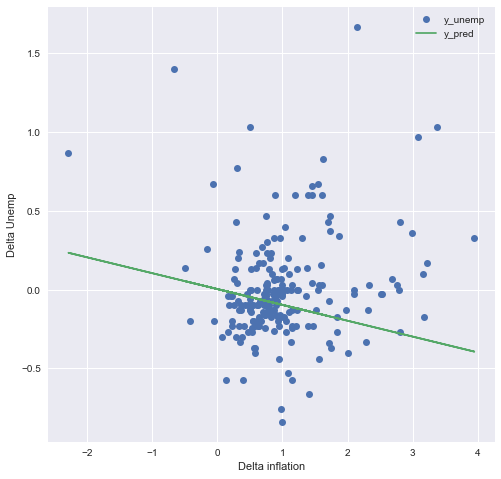

In [79]:
#plot
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(inf,y_unemp,'o')
ax.plot(inf,beta_25[0]+inf*beta_25[1])
ax.set_ylabel("Delta Unemp")
ax.set_xlabel("Delta inflation")
ax.legend(["y_unemp","y_pred"])
#plt.xticks([0,50,100,150,200],[quaterly_raw.index.tolist()[i] for i in [6,56,106,156,206]])
plt.show()

#### 6) Tester l’autocorrélation des erreurs.

In [80]:
#calcul des residus
residual_25 = y_unemp - np.dot(X_inf,beta_25)

Faisons la regression de u_t sur u_t-1, on effectue la regression suivante $u_t = \rho* u_{t-1} + e$

In [81]:
#OLS residual on residual lag1
residual_25_lag1 = np.zeros(residual_25.shape[0])
residual_25_lag1[1:] = residual_25[:-1]
X_residual_25_lag1 = residual_25_lag1.reshape(-1,1)
ro_residual_25_lag1,_ = compute_OLS(X_residual_25_lag1,residual_25)

In [83]:
print("valeur de rho : {}".format(ro_residual_25_lag1[0]))

valeur de rho : 0.6311721896678755


Testons la non significativité du coefficient associé au lag d'ordre 1, H0: $\rho$ = 0 :

In [84]:
residual_residual = residual_25 - np.dot(X_residual_25_lag1,ro_residual_25_lag1)
sig2_residual_residual = np.dot(np.transpose(residual_residual.reshape(-1,1)),residual_residual.reshape(-1,1))/(X_residual_25_lag1.shape[0]-1)
std_residual_residual = np.sqrt(np.diag(sig2_residual_residual*np.linalg.inv(np.dot(np.transpose(X_residual_25_lag1.reshape(-1,1)),X_residual_25_lag1.reshape(-1,1)))))

t_residual_residual = ro_residual_25_lag1/std_residual_residual
t_residual_residual
                               
                                

array([11.63345069])

In [85]:
p_value = sp.stats.t.ppf(0.995, X_residual_25_lag1.shape[0] - 1)
print(p_value)

2.600024105383646


On rejette H0 à 1% de risque de première espèce (test bilateral), il y a autocorrélation des erreurs.

#### 7) Corriger l’autocorrélation des erreurs par la méthode vue en cours.

Correction par les MCG : $y_{t} - \rho*y_{t-1}$ à t=1 $\sqrt{1-\rho^2*y_1}$
même chose pour X

In [86]:
#compute new y from 1 to n
y_part = np.array([y_unemp[i]-ro_residual_25_lag1*y_unemp[i-1] for i in range(1,y_unemp.shape[0])])

#compute new X from 1 to n
X_part = np.zeros((X_inf.shape[0]-1,X_inf.shape[1]))
for i in range(1,X_inf.shape[0]):
    X_part[i-1] = X_inf[i] - ro_residual_25_lag1*X_inf[i-1]

#mcg correction
new_y = np.vstack((np.sqrt(1-ro_residual_25_lag1**2)*y_unemp[0].reshape(-1,1),y_part.reshape(-1,1)))
new_X_inf = np.vstack((np.transpose((np.sqrt(1-ro_residual_25_lag1**2)*X_inf[0]).reshape(-1,1)),X_part))

In [87]:
#let's apply MCO to the new model
beta_new, _ = compute_OLS(new_X_inf,new_y)
print(beta_new)

[[ 0.00062567]
 [-0.0270679 ]]


In [88]:
#calcul des residus
residual_new = new_y.reshape(-1) - np.dot(new_X_inf,beta_new).reshape(-1)

#OLS residual on residual lag1
residual_new_lag1 = np.zeros(residual_new.shape[0])
residual_new_lag1[1:] = residual_new[:-1]
X_residual_new_lag1 = residual_new_lag1.reshape(-1,1)
ro_residual_new_lag1,_ = compute_OLS(X_residual_new_lag1,residual_new)
ro_residual_new_lag1

array([0.04612099])

On constate que rho est divisé par un facteur ~10, la correction MCG est effective. 

#### 8) Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.

Test changement de structure : considérons deux sous périodes de .. observations|trimestres

In [89]:
X_part_1 = X_inf[:100]
y_part_1 = y_unemp[:100]

X_part_2 = X_inf[100:200]
y_part_2 = y_unemp[100:200]

Effectuons un test de changement de structure du chomâge en fonction de l'inflation

In [90]:
#compute ols for each par
beta_part_1,_ = compute_OLS(X_part_1,y_part_1)
beta_part_2,_ = compute_OLS(X_part_2,y_part_2)
print("coeff partie 1 : {}".format(beta_part_1))
print("coeff partie 2 : {}".format(beta_part_2))

coeff partie 1 : [ 0.00045492 -0.27106835]
coeff partie 2 : [ 0.01865703 -0.00348421]


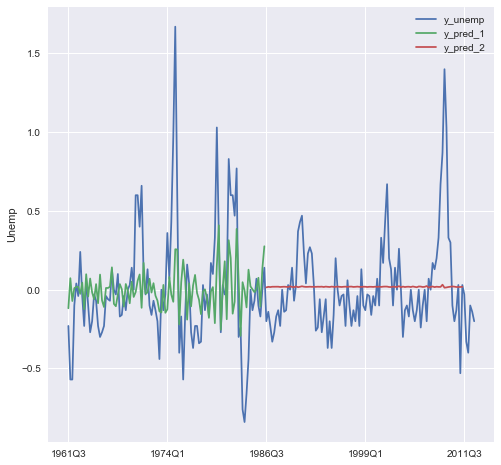

In [91]:
#plot real curve vs prediction on each part
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(y_unemp)
ax.plot(range(0,100),beta_part_1[0]+X_part_1[:,1]*beta_part_1[1])
ax.plot(range(100,200),beta_part_2[0]+X_part_2[:,1]*beta_part_2[1])
ax.set_ylabel("Unemp")
ax.legend(["y_unemp","y_pred_1","y_pred_2"])
plt.xticks([0,50,100,150,200],[quaterly_raw.index.tolist()[i] for i in [6,56,106,156,206]])
plt.show()

On peut constater que le coefficent associé à l'inflation pour expliquer le chomage est complètement différent d'une période à l'autre, il y a à priori un changement de structure. Nous pourrions confirmer cela à l'aide d'un test statistique : H0 -> les coefficients sont égaux sur les deux périodes 
<=> $y_t = (\beta_0 + \gamma_0*D_\tau) + (\beta_1 + \gamma_1*D\tau)*inf$, avec Dt = 0 pour les 100 premières periodes, Dt = 1 pour les 100 dernières. Si les gamma_i = 0 alors on n'a pas de changement de structure. 

Ici on test donc pour to=103 periodes ce qui correspond au Q3 de 1986, H0: gamma_i=0 pour tout i

In [92]:
D_to = np.zeros(200)
D_to[100:] = 1

X_test_8 = np.transpose(np.vstack((np.ones(200),D_to,inf[:200],D_to*inf[:200])))
beta_test,_ = compute_OLS(X_test_8,y_unemp[:200])
pd.DataFrame(beta_test,index=["cste","gamma_0.cste","inf","gamma_1.inf"],columns=["coeff"])

,coeff
cste,-0.160866
gamma_0.cste,0.286084
inf,0.124244
gamma_1.inf,-0.271012


In [93]:
#let's test  gamma_1 =0
beta_test_restricted = beta_test.copy()
beta_test_restricted[[1,3]] = 0
F_stat,p_val = compute_Fisher(X_test_8,y_unemp[:200],beta_test,beta_test_restricted,1)
#1-Proba d'être en dessous de la F-stats
print("proba d'être au dessus de la F-stat calculée : {}".format(p_val))

proba d'être au dessus de la F-stat calculée : 1.5068255699857147e-06


Dans le cadre d'un test bilatéral (considérant que les gamma_i peuvent être positif ou négatif)  on rejette H_0 avec un risque de 1%. On peut donc considérer un changement de structure au Q3 1986. En observant la courbe on peut déduire que ce changement de structure est principalement causé par la période 1970-1980, période riche en variations par rapport aux autres.

#### 9) Estimer la courbe de Philips en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur

In [94]:
X_inf_lag4 = np.transpose(np.vstack((np.ones(inf.shape[0]),inf-inf1,inf1-inf2,inf2-inf3,inf3-inf4,inf4-inf5)))
beta_lag4,_ = compute_OLS(X_inf_lag4,y_unemp)
pd.DataFrame(beta_lag4, index=["cste","inf_diff","lag1","lag2","lag3","lag4"],columns=["coeff"])

,coeff
cste,0.004549
inf_diff,-0.166801
lag1,-0.140475
lag2,-0.149819
lag3,-0.046722
lag4,0.005916


In [95]:
pd.DataFrame(X_inf_lag4,columns=["cste","inf_diff","lag1","lag2","lag3","lag4"]).head()

,cste,inf_diff,lag1,lag2,lag3,lag4
0,1.0,0.435792,-0.234990,-0.440631,0.574473,-0.510595
1,1.0,-0.268724,0.435792,-0.234990,-0.440631,0.574473
2,1.0,0.266577,-0.268724,0.435792,-0.234990,-0.440631
3,1.0,-0.034806,0.266577,-0.268724,0.435792,-0.234990
4,1.0,-0.067511,-0.034806,0.266577,-0.268724,0.435792


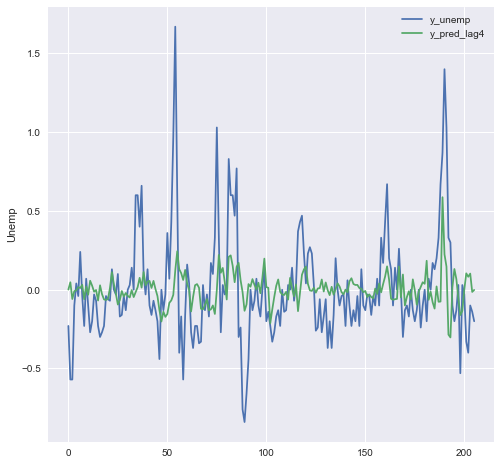

In [96]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(y_unemp)
ax.plot(beta_lag4[0]+np.dot(X_inf_lag4[:,1:],beta_lag4[1:]))
ax.set_ylabel("Unemp")
ax.legend(["y_unemp","y_pred_lag4"])

Testons la non causalité de l'inflation sur le chômage ainsi posons H0 : beta_i =0, ou beta_i est le coefficent associé au lag_i de l'inflation <=> non causalité de l'inflation et de ses lags

In [97]:
#H0 : all lags coeff = 0
beta_lag4_restricted = beta_lag4.copy()
beta_lag4_restricted[2:] = 0
F_stat,p_val = compute_Fisher(X_inf_lag4,y_unemp,beta_lag4,beta_lag4_restricted,4)
print("All lags = 0, proba d'être au dessus de la F-stat calculée : {}".format(p_val))

beta_lag4_restricted = beta_lag4.copy()
beta_lag4_restricted[3:] = 0
F_stat,p_val = compute_Fisher(X_inf_lag4,y_unemp,beta_lag4,beta_lag4_restricted,3)
print("lags 2,3,4 = 0, proba d'être au dessus de la F-stat calculée : {}".format(p_val))

beta_lag4_restricted = beta_lag4.copy()
beta_lag4_restricted[4:] = 0
F_stat,p_val = compute_Fisher(X_inf_lag4,y_unemp,beta_lag4,beta_lag4_restricted,2)
print("lags 3,4 = 0, proba d'être au dessus de la F-stat calculée : {}".format(p_val))

All lags = 0, proba d'être au dessus de la F-stat calculée : 0.006764504228246593
lags 2,3,4 = 0, proba d'être au dessus de la F-stat calculée : 0.008766364118298453
lags 3,4 = 0, proba d'être au dessus de la F-stat calculée : 0.5185320625064371


Les lags 3 et 4 sont significatif dans l'explication de unemp

Rejette H0 à 1% (test bilateral), Les lags sont significatifs dans l'explication du chomage

#### 10) Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long terme de l’inflation sur le chômage.

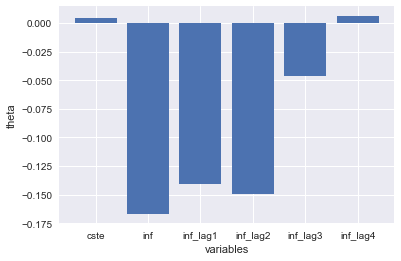

In [98]:
plt.bar(range(6),beta_lag4)
plt.xlabel("variables")
plt.ylabel("theta")
plt.xticks(range(6),["cste",'inf','inf_lag1','inf_lag2','inf_lag3','inf_lag4','inf_lag5'])
plt.show()

On a une relation inverse entre inflation et chomage à court terme (jusqu'au lag 2 soit 6 mois) : une variation positive de l'inflation engendre une variation négative du chomage. 

En se basant sur les coefficients associés aux lags 3 et lags 4 on constate qu'à long terme l'inflation n'est pas significatif sur le chomage